In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/EcommerceDAnalysis1/data_rfm_pcapped_3dt1.pkl'
data_rfm_pcapped_3dt1 = pd.read_pickle(file_path, )

# Inspect the data
# Percentage based capped data 0.1% & 99%
print(data_rfm_pcapped_3dt1.head())
print(data_rfm_pcapped_3dt1.info())
print(data_rfm_pcapped_3dt1.shape)
print(data_rfm_pcapped_3dt1.describe().T)
print(data_rfm_pcapped_3dt1.nunique())
print(data_rfm_pcapped_3dt1.isnull().sum())
print(data_rfm_pcapped_3dt1.duplicated().sum())
print(data_rfm_pcapped_3dt1[~data_rfm_pcapped_3dt1.isnull().any(axis=1) & ~data_rfm_pcapped_3dt1.duplicated()])
print((data_rfm_pcapped_3dt1['Quantity'] < 0).sum(), (data_rfm_pcapped_3dt1['UnitPrice'] < 0).sum())
print(data_rfm_pcapped_3dt1.columns)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   

   DayOfWeek  ...  Month  Year  recency  frequency  monetary  recency_score  \
0          2  ...     12  2010 

In [ ]:
data_pcapped_3 = data_rfm_pcapped_3dt1.copy()

# Drop the specified columns
columns_to_drop = ['DayOfWeek', 'HourOfDay', 'Month', 'Year', 'recency',
                   'frequency', 'monetary', 'recency_score', 'frequency_score',
                   'monetary_score', 'RFM_Score', 'Segment']

data_pcapped_3 = data_pcapped_3.drop(columns=columns_to_drop)

# Check the result
print(data_pcapped_3.columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice'],
      dtype='object')


In [ ]:
# Copy the data for invoice date feature extraction
data_invoice_date = data_pcapped_3.copy()

# Convert InvoiceDate to datetime
data_invoice_date['InvoiceDate'] = pd.to_datetime(data_invoice_date['InvoiceDate'], format='%m/%d/%Y %H:%M')

# Extract additional features from InvoiceDate
data_invoice_date['DayOfWeek'] = data_invoice_date['InvoiceDate'].dt.dayofweek
data_invoice_date['HourOfDay'] = data_invoice_date['InvoiceDate'].dt.hour
data_invoice_date['Month'] = data_invoice_date['InvoiceDate'].dt.month
data_invoice_date['Year'] = data_invoice_date['InvoiceDate'].dt.year

# Check the newly extracted features
print(data_invoice_date[['InvoiceDate', 'DayOfWeek', 'HourOfDay', 'Month', 'Year']].head())
print(data_invoice_date.head())
print(data_invoice_date.info())
print(data_invoice_date.isnull().sum())
print(data_invoice_date.nunique())
print(data_invoice_date.describe().T)

          InvoiceDate  DayOfWeek  HourOfDay  Month  Year
0 2010-12-01 08:26:00          2          8     12  2010
1 2010-12-01 08:26:00          2          8     12  2010
2 2010-12-01 08:26:00          2          8     12  2010
3 2010-12-01 08:26:00          2          8     12  2010
4 2010-12-01 08:26:00          2          8     12  2010
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34 

In [ ]:
import pandas as pd

# Create a copy of the original dataframe for Product-Based RFM calculation
data_product_rfm = data_invoice_date.copy()

# Recency: Calculate the last purchase date for each Customer-Product combination
most_recent_purchase_date = data_product_rfm.groupby(['CustomerID', 'StockCode'])['InvoiceDate'].max().reset_index()
most_recent_purchase_date.rename(columns={'InvoiceDate': 'LastPurchaseDate'}, inplace=True)

# Merge with the original dataframe to calculate Recency for each row
data_product_rfm = data_product_rfm.merge(most_recent_purchase_date, on=['CustomerID', 'StockCode'], how='left')

# Calculate Recency: Days since last purchase from the max date in dataset
data_product_rfm['Recency'] = (data_product_rfm['InvoiceDate'].max() - data_product_rfm['LastPurchaseDate']).dt.days

# Frequency: Count the number of unique invoices per customer-product combination
frequency = data_product_rfm.groupby(['CustomerID', 'StockCode'])['InvoiceNo'].nunique().reset_index()
frequency.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

# Merge Frequency into the dataframe
data_product_rfm = data_product_rfm.merge(frequency, on=['CustomerID', 'StockCode'], how='left')

# Monetary: Sum of total spending per customer-product combination
monetary = data_product_rfm.groupby(['CustomerID', 'StockCode'])['TotalPrice'].sum().reset_index()
monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

# Merge Monetary into the dataframe
data_product_rfm = data_product_rfm.merge(monetary, on=['CustomerID', 'StockCode'], how='left')

# Removed drop_duplicates line to keep multiple rows per CustomerID-StockCode combination

# Handle missing values (if any)
data_product_rfm.fillna({'Recency': data_product_rfm['Recency'].max(), 'Frequency': 0, 'Monetary': 0}, inplace=True)

# Select final features for modeling
final_rfm_data = data_product_rfm[['CustomerID', 'StockCode', 'Recency', 'Frequency', 'Monetary']]

# Display results
print(final_rfm_data.head())
print(final_rfm_data.info())

# Create a Repurchase flag: A repurchase is when the same CustomerID buys the same StockCode more than once
data_product_rfm['Repurchase'] = data_product_rfm.groupby(['CustomerID', 'StockCode'])['InvoiceNo'].transform('count') > 1

# Convert boolean to integer
data_product_rfm['Repurchase'] = data_product_rfm['Repurchase'].astype(int)

# Check distribution of repurchase instances
print(data_product_rfm['Repurchase'].value_counts(normalize=True))


   CustomerID StockCode  Recency  Frequency  Monetary
0       17850    85123A      371         17    315.90
1       17850     71053      371         17    413.58
2       17850    84406B      371         15    297.00
3       17850    84029G      371         17    372.90
4       17850    84029E      371         17    352.56
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522695 entries, 0 to 522694
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CustomerID  522695 non-null  int64  
 1   StockCode   522695 non-null  object 
 2   Recency     522695 non-null  int64  
 3   Frequency   522695 non-null  int64  
 4   Monetary    522695 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 19.9+ MB
None
Repurchase
0    0.625719
1    0.374281
Name: proportion, dtype: float64


In [ ]:
print(data_product_rfm.head())
print(data_product_rfm.info())
print(data_product_rfm.describe().T)
print(data_product_rfm.nunique())
print(data_product_rfm.isnull().sum())
print(data_product_rfm.duplicated().sum())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34   

   DayOfWeek  HourOfDay  Month  Year    LastPurchaseDate  Recency  Frequency  \
0          2          8     12

In [ ]:
# Check if there are any duplicates based on CustomerID and StockCode
duplicates = data_product_rfm[data_product_rfm.duplicated(subset=['CustomerID', 'StockCode'], keep=False)]
print(duplicates[['CustomerID', 'StockCode']].head())


   CustomerID StockCode
0       17850    85123A
1       17850     71053
2       17850    84406B
3       17850    84029G
4       17850    84029E


In [ ]:
# Create a copy to avoid modifying the original dataframe
data_product1 = data_product_rfm.copy()

# Count the number of purchases for each CustomerID and StockCode combination
purchase_counts = data_product1.groupby(['CustomerID', 'StockCode']).size().reset_index(name='PurchaseCount')

# Merge purchase counts back into the original dataframe
data_product1 = data_product1.merge(purchase_counts, on=['CustomerID', 'StockCode'], how='left')

# Sort by CustomerID and InvoiceDate to enable 'Next Purchase Date' logic
data_product1 = data_product1.sort_values(by=['CustomerID', 'InvoiceDate'])

# Step 1: Shift the 'InvoiceDate' to create 'Next_Purchase_Date' for each customer and StockCode
data_product1['Next_Purchase_Date'] = data_product1.groupby(['CustomerID', 'StockCode'])['InvoiceDate'].shift(-1)

# Step 2: Fill NaT values in 'Next_Purchase_Date' (i.e., no next purchase)
# Fill NaT values in 'Next_Purchase_Date' (i.e., no next purchase) with a far future date
data_product1['Next_Purchase_Date'] = data_product1['Next_Purchase_Date'].fillna(pd.Timestamp('2100-12-31'))  # Use a far future date
 # Use a far future date

# Step 3: Create 'Repurchase_Behavior' flag: If the next purchase date is within 30 days, mark as repurchase (1)
data_product1['Repurchase_Behavior'] = data_product1.apply(
    lambda row: 1 if ((row['Next_Purchase_Date'] - row['InvoiceDate']).days <= 180)
               else 0, axis=1)

# Step 4: Drop the 'Next_Purchase_Date' column, as it's no longer needed
data_product1.drop(columns=['Next_Purchase_Date'], inplace=True)

# Step 5: Check the distribution of repurchase behaviors


# Step 6: Display the final result with relevant columns
print(data_product1[['CustomerID', 'StockCode', 'InvoiceDate', 'Repurchase_Behavior']].head())


       CustomerID StockCode         InvoiceDate  Repurchase_Behavior
14329       12347     85116 2010-12-07 14:57:00                    1
14330       12347     22375 2010-12-07 14:57:00                    1
14331       12347     71477 2010-12-07 14:57:00                    0
14332       12347     22492 2010-12-07 14:57:00                    1
14333       12347     22771 2010-12-07 14:57:00                    0


In [ ]:
print(data_product1['Repurchase_Behavior'].value_counts())

Repurchase_Behavior
0    402980
1    119715
Name: count, dtype: int64


In [ ]:
print(data_product1.head())
print(data_product1.info())
print(data_product1.describe().T)
print(data_product1.nunique())
print(data_product1.isnull().sum())
print(data_product1.duplicated().sum())

      InvoiceNo StockCode                          Description  Quantity  \
14329    537626     85116      BLACK CANDELABRA T-LIGHT HOLDER        12   
14330    537626     22375    AIRLINE BAG VINTAGE JET SET BROWN         4   
14331    537626     71477    COLOUR GLASS. STAR T-LIGHT HOLDER        12   
14332    537626     22492              MINI PAINT SET VINTAGE         36   
14333    537626     22771  CLEAR DRAWER KNOB ACRYLIC EDWARDIAN        12   

              InvoiceDate  UnitPrice  CustomerID  Country  TotalPrice  \
14329 2010-12-07 14:57:00       2.10       12347  Iceland        25.2   
14330 2010-12-07 14:57:00       4.25       12347  Iceland        17.0   
14331 2010-12-07 14:57:00       3.25       12347  Iceland        39.0   
14332 2010-12-07 14:57:00       0.65       12347  Iceland        23.4   
14333 2010-12-07 14:57:00       1.25       12347  Iceland        15.0   

       DayOfWeek  HourOfDay  Month  Year    LastPurchaseDate  Recency  \
14329          1         14    

In [ ]:
data_preprocessed = data_product1.copy()
# Drop irrelevant columns
columns_to_drop = ['InvoiceNo', 'Description', 'Country', 'InvoiceDate', 'LastPurchaseDate']
data_preprocessed = data_preprocessed.drop(columns=columns_to_drop)

# Check the first few rows to ensure the columns were dropped
print(data_preprocessed.head())


      StockCode  Quantity  UnitPrice  CustomerID  TotalPrice  DayOfWeek  \
14329     85116        12       2.10       12347        25.2          1   
14330     22375         4       4.25       12347        17.0          1   
14331     71477        12       3.25       12347        39.0          1   
14332     22492        36       0.65       12347        23.4          1   
14333     22771        12       1.25       12347        15.0          1   

       HourOfDay  Month  Year  Recency  Frequency  Monetary  Repurchase  \
14329         14     12  2010      316          2      37.8           1   
14330         14     12  2010       39          6     119.0           1   
14331         14     12  2010      366          1      39.0           0   
14332         14     12  2010       39          3      70.2           1   
14333         14     12  2010      366          1      15.0           0   

       PurchaseCount  Repurchase_Behavior  
14329              2                    1  
14330     

In [ ]:
print(data_preprocessed.info())


<class 'pandas.core.frame.DataFrame'>
Index: 522695 entries, 14329 to 408651
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   StockCode            522695 non-null  object 
 1   Quantity             522695 non-null  int64  
 2   UnitPrice            522695 non-null  float64
 3   CustomerID           522695 non-null  int64  
 4   TotalPrice           522695 non-null  float64
 5   DayOfWeek            522695 non-null  int32  
 6   HourOfDay            522695 non-null  int32  
 7   Month                522695 non-null  int32  
 8   Year                 522695 non-null  int32  
 9   Recency              522695 non-null  int64  
 10  Frequency            522695 non-null  int64  
 11  Monetary             522695 non-null  float64
 12  Repurchase           522695 non-null  int64  
 13  PurchaseCount        522695 non-null  int64  
 14  Repurchase_Behavior  522695 non-null  int64  
dtypes: float64(3), int

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the data
data_encoded = data_preprocessed.copy()

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode only 'StockCode'
data_encoded['StockCode'] = label_encoder.fit_transform(data_encoded['StockCode'])

# Check the first few rows to ensure encoding was successful
print(data_encoded[['StockCode', 'CustomerID']].head())
print(data_encoded.head())
print(data_encoded.info())

       StockCode  CustomerID
14329       3402       12347
14330       1268       12347
14331       2736       12347
14332       1374       12347
14333       1643       12347
       StockCode  Quantity  UnitPrice  CustomerID  TotalPrice  DayOfWeek  \
14329       3402        12       2.10       12347        25.2          1   
14330       1268         4       4.25       12347        17.0          1   
14331       2736        12       3.25       12347        39.0          1   
14332       1374        36       0.65       12347        23.4          1   
14333       1643        12       1.25       12347        15.0          1   

       HourOfDay  Month  Year  Recency  Frequency  Monetary  Repurchase  \
14329         14     12  2010      316          2      37.8           1   
14330         14     12  2010       39          6     119.0           1   
14331         14     12  2010      366          1      39.0           0   
14332         14     12  2010       39          3      70.2          

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a copy of the data
data_scaled = data_encoded.copy()

# Select the numerical columns to scale
numerical_columns_to_scale = ['Quantity', 'UnitPrice', 'TotalPrice', 'Recency', 'Frequency', 'Monetary']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling to the selected numerical columns
data_scaled[numerical_columns_to_scale] = scaler.fit_transform(data_scaled[numerical_columns_to_scale])

# Check the first few rows to ensure scaling was applied
print(data_scaled.head())
print(data_scaled.info())

       StockCode  Quantity  UnitPrice  CustomerID  TotalPrice  DayOfWeek  \
14329       3402  0.204503  -0.348438       12347    0.327834          1   
14330       1268 -0.317069   0.340829       12347    0.014026          1   
14331       2736  0.204503   0.020239       12347    0.855949          1   
14332       1374  1.769220  -0.813293       12347    0.258949          1   
14333       1643  0.204503  -0.620939       12347   -0.062512          1   

       HourOfDay  Month  Year   Recency  Frequency  Monetary  Repurchase  \
14329         14     12  2010  1.644055  -0.083729 -0.068151           1   
14330         14     12  2010 -0.782645   1.110424  0.414142           1   
14331         14     12  2010  2.082087  -0.382267 -0.061023           0   
14332         14     12  2010 -0.782645   0.214810  0.124291           1   
14333         14     12  2010  2.082087  -0.382267 -0.203573           0   

       PurchaseCount  Repurchase_Behavior  
14329              2                    1 

In [ ]:
from sklearn.model_selection import train_test_split

# Define the features (X) and the target variable (y)
X = data_scaled.drop('Repurchase_Behavior', axis=1)  # Features (all columns except the target)
y = data_scaled['Repurchase_Behavior']  # Target variable (Repurchase Behavior)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (418156, 14)
X_test shape: (104539, 14)
y_train shape: (418156,)
y_test shape: (104539,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Initialize Logistic Regression with class weights balanced for imbalanced data
log_reg_model = LogisticRegression(class_weight='balanced', random_state=42)

# Fit the model to the training data
log_reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Output the evaluation metrics
print(f"Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{cm}")


Logistic Regression Model Evaluation:
Accuracy: 0.8890
Precision: 0.7164
Recall: 0.8574
F1-Score: 0.7806
ROC-AUC: 0.8779
Confusion Matrix:
[[72288  8174]
 [ 3433 20644]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Initialize RandomForestClassifier with class weights balanced for imbalanced data
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Output the evaluation metrics
print(f"Random Forest Model Evaluation:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print(f"ROC-AUC: {roc_auc_rf:.4f}")
print(f"Confusion Matrix:\n{cm_rf}")


Random Forest Model Evaluation:
Accuracy: 0.9664
Precision: 0.9320
Recall: 0.9213
F1-Score: 0.9266
ROC-AUC: 0.9506
Confusion Matrix:
[[78844  1618]
 [ 1896 22181]]


In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Output the evaluation metrics
print(f"XGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-Score: {f1_xgb:.4f}")
print(f"ROC-AUC: {roc_auc_xgb:.4f}")
print(f"Confusion Matrix:\n{cm_xgb}")


XGBoost Model Evaluation:
Accuracy: 0.9674
Precision: 0.9008
Recall: 0.9646
F1-Score: 0.9316
ROC-AUC: 0.9664
Confusion Matrix:
[[77905  2557]
 [  852 23225]]


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Initialize the CatBoost model
catboost_model = CatBoostClassifier(
    iterations=500,        # Number of boosting iterations
    depth=6,               # Depth of the trees
    learning_rate=0.1,     # Learning rate for the model
    loss_function='Logloss', # Binary classification loss function
    cat_features=[],       # Specify categorical features if needed
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), # Handling class imbalance
    random_state=42,       # For reproducibility
    verbose=100            # Print progress every 100 iterations
)

# Fit the model to the training data
catboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_catboost = catboost_model.predict(X_test)

# Calculate evaluation metrics
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
precision_catboost = precision_score(y_test, y_pred_catboost)
recall_catboost = recall_score(y_test, y_pred_catboost)
f1_catboost = f1_score(y_test, y_pred_catboost)
roc_auc_catboost = roc_auc_score(y_test, y_pred_catboost)
cm_catboost = confusion_matrix(y_test, y_pred_catboost)

# Output the evaluation metrics
print(f"CatBoost Model Evaluation:")
print(f"Accuracy: {accuracy_catboost:.4f}")
print(f"Precision: {precision_catboost:.4f}")
print(f"Recall: {recall_catboost:.4f}")
print(f"F1-Score: {f1_catboost:.4f}")
print(f"ROC-AUC: {roc_auc_catboost:.4f}")
print(f"Confusion Matrix:\n{cm_catboost}")


0:	learn: 0.4919429	total: 385ms	remaining: 3m 12s
100:	learn: 0.1021731	total: 35.1s	remaining: 2m 18s
200:	learn: 0.0911500	total: 49.4s	remaining: 1m 13s
300:	learn: 0.0839120	total: 1m 1s	remaining: 40.5s
400:	learn: 0.0793281	total: 1m 13s	remaining: 18.1s
499:	learn: 0.0764831	total: 1m 25s	remaining: 0us
CatBoost Model Evaluation:
Accuracy: 0.9660
Precision: 0.8954
Recall: 0.9653
F1-Score: 0.9290
ROC-AUC: 0.9658
Confusion Matrix:
[[77746  2716]
 [  836 23241]]


In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import numpy as np

# Initialize the XGBoost model
xgb_model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

# Output the results
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of Cross-Validation Accuracy: {np.std(cv_scores):.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:00:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:00:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:00:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:00:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:01:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-Validation Accuracy Scores: [0.97433997 0.97327546 0.97383745 0.97241454 0.97372984]
Mean Cross-Validation Accuracy: 0.9735
Standard Deviation of Cross-Validation Accuracy: 0.0006


In [ ]:
import xgboost as xgb
import numpy as np

# Prepare the data for xgboost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the parameters for cross-validation
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
}

# Perform cross-validation with 5 folds
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Adjust the number of boosting rounds
    nfold=5,  # Number of folds
    early_stopping_rounds=10,  # Stop early if no improvement
    metrics="logloss",  # Metrics for evaluation
    as_pandas=True,  # Return results as pandas DataFrame
)

# Output the results
print(f"Cross-Validation Logloss Scores:\n{cv_results}")
print(f"Mean Logloss: {cv_results['test-logloss-mean'].min():.4f}")
print(f"Optimal Number of Rounds: {cv_results['test-logloss-mean'].idxmin()}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:50:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:50:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:50:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:50:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-Validation Logloss Scores:
     train-logloss-mean  train-logloss-std  test-logloss-mean  \
0              0.367690           0.000376           0.367766   
1              0.286721           0.000351           0.286846   
2              0.235292           0.000628           0.235518   
3              0.200508           0.000557           0.200809   
4              0.176555           0.000331           0.176938   
..                  ...                ...                ...   
252            0.039337           0.000514           0.060728   
253            0.039284           0.000500           0.060741   
254            0.039231           0.000499           0.060747   
255            0.039134           0.000541           0.060708   
256            0.039052           0.000560           0.060687   

     test-logloss-std  
0            0.000907  
1            0.000826  
2            0.001239  
3            0.000812  
4            0.000825  
..                ...  
252          0.000

In [ ]:
from catboost import CatBoostClassifier, cv, Pool
from sklearn.model_selection import train_test_split

# Assuming data_encoded is the dataset you want to use

# Separate features and target
X = data_encoded.drop(columns=['Repurchase_Behavior'])
y = data_encoded['Repurchase_Behavior']

# Define the CatBoost model
catboost_model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',  # Specify the loss function for binary classification
    cat_features=[],  # List of categorical columns if any
    custom_metric=['AUC', 'Accuracy']
)

# Perform cross-validation
cv_results = cv(
    Pool(X, label=y),  # Convert the dataset to Pool format
    catboost_model.get_params(),  # Get the default parameters
    fold_count=5,  # 5-fold cross-validation
    plot=True  # Plot results
)

# Display cross-validation results
print(cv_results)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
64:	learn: 0.0950597	test: 0.0958777	best: 0.0958777 (64)	total: 9.4s	remaining: 2m 15s
65:	learn: 0.0942104	test: 0.0950208	best: 0.0950208 (65)	total: 9.66s	remaining: 2m 16s
66:	learn: 0.0936940	test: 0.0944862	best: 0.0944862 (66)	total: 9.89s	remaining: 2m 17s
67:	learn: 0.0932856	test: 0.0940940	best: 0.0940940 (67)	total: 10.1s	remaining: 2m 19s
68:	learn: 0.0928675	test: 0.0936829	best: 0.0936829 (68)	total: 10.4s	remaining: 2m 20s
69:	learn: 0.0924325	test: 0.0932393	best: 0.0932393 (69)	total: 10.7s	remaining: 2m 22s
70:	learn: 0.0923545	test: 0.0931677	best: 0.0931677 (70)	total: 11s	remaining: 2m 23s
71:	learn: 0.0922313	test: 0.0930535	best: 0.0930535 (71)	total: 11.2s	remaining: 2m 24s
72:	learn: 0.0918545	test: 0.0927705	best: 0.0927705 (72)	total: 11.5s	remaining: 2m 25s
73:	learn: 0.0916632	test: 0.0926067	best: 0.0926067 (73)	total: 11.7s	remaining: 2m 26s
74:	learn: 0.0914599	test: 0.0924544	best: 0.0924544 (74)	tota

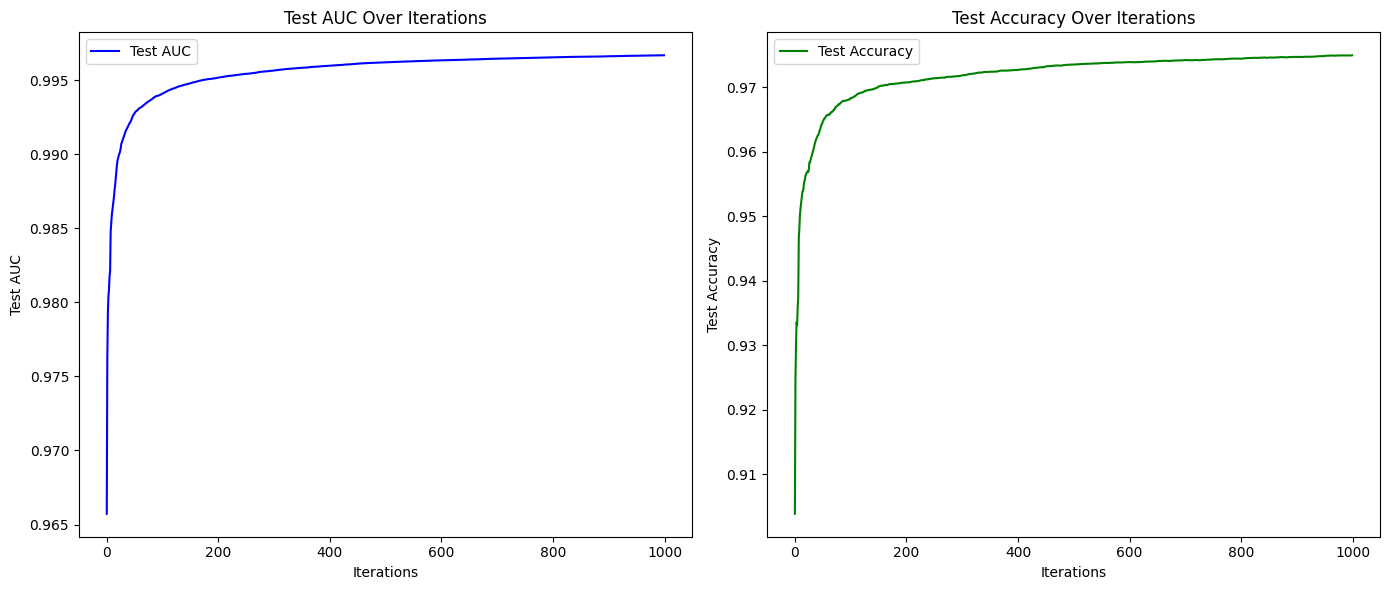

In [ ]:
import matplotlib.pyplot as plt

# Extracting values for plotting
iterations = cv_results['iterations']
test_auc = cv_results['test-AUC-mean']
test_accuracy = cv_results['test-Accuracy-mean']

# Plotting AUC and Accuracy
plt.figure(figsize=(14, 6))

# Plot AUC
plt.subplot(1, 2, 1)
plt.plot(iterations, test_auc, label='Test AUC', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Test AUC')
plt.title('Test AUC Over Iterations')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(iterations, test_accuracy, label='Test Accuracy', color='green')
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Over Iterations')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Initialize the CatBoost model
catboost_model = CatBoostClassifier(
    iterations=500,        # Number of boosting iterations
    depth=6,               # Depth of the trees
    learning_rate=0.1,     # Learning rate for the model
    loss_function='Logloss', # Binary classification loss function
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), # Handling class imbalance
    random_state=42,       # For reproducibility
    verbose=100            # Print progress every 100 iterations
)

# Ensure the model is trained on the training data
catboost_model.fit(X_train, y_train)

# After training, make predictions on the test set
y_pred_catboost = catboost_model.predict(X_test)

# Calculate evaluation metrics
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
precision_catboost = precision_score(y_test, y_pred_catboost)
recall_catboost = recall_score(y_test, y_pred_catboost)
f1_catboost = f1_score(y_test, y_pred_catboost)
roc_auc_catboost = roc_auc_score(y_test, catboost_model.predict_proba(X_test)[:, 1])  # Use predict_proba for AUC
cm_catboost = confusion_matrix(y_test, y_pred_catboost)

# Output the evaluation metrics
print(f"CatBoost Model Evaluation:")
print(f"Accuracy: {accuracy_catboost:.4f}")
print(f"Precision: {precision_catboost:.4f}")
print(f"Recall: {recall_catboost:.4f}")
print(f"F1-Score: {f1_catboost:.4f}")
print(f"ROC-AUC: {roc_auc_catboost:.4f}")
print(f"Confusion Matrix:\n{cm_catboost}")


0:	learn: 0.4919429	total: 280ms	remaining: 2m 19s
100:	learn: 0.1021731	total: 13.5s	remaining: 53.5s
200:	learn: 0.0911500	total: 24s	remaining: 35.6s
300:	learn: 0.0839120	total: 35.8s	remaining: 23.7s
400:	learn: 0.0793281	total: 47.9s	remaining: 11.8s
499:	learn: 0.0764831	total: 59.7s	remaining: 0us
CatBoost Model Evaluation:
Accuracy: 0.9660
Precision: 0.8954
Recall: 0.9653
F1-Score: 0.9290
ROC-AUC: 0.9959
Confusion Matrix:
[[77746  2716]
 [  836 23241]]


In [ ]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.0 MB/s eta 0:00:00


In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    # Define the hyperparameters to tune
    iterations = trial.suggest_int('iterations', 500, 1000)
    depth = trial.suggest_int('depth', 6, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)  # Using suggest_float with log=True for learning rate
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 5)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0.0, 1.0)  # Using suggest_float for uniform distribution
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.7, 1.0)  # Using suggest_float for uniform distribution

    # Initialize the model
    model = CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=bagging_temperature,
        colsample_bylevel=colsample_bylevel,
        loss_function='Logloss',
        random_state=42,
        verbose=0
    )

    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy  # Maximizing accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and score
print(f"Best trial: {study.best_trial.params}")
print(f"Best score: {study.best_trial.value}")


[I 2025-03-05 11:43:49,060] A new study created in memory with name: no-name-0d0070e7-5c38-4315-8016-268b1740f405
[I 2025-03-05 11:45:39,596] Trial 0 finished with value: 0.9744305952802303 and parameters: {'iterations': 804, 'depth': 8, 'learning_rate': 0.0740353058241092, 'l2_leaf_reg': 1, 'bagging_temperature': 0.7105225284220352, 'colsample_bylevel': 0.9809784088138565}. Best is trial 0 with value: 0.9744305952802303.
[I 2025-03-05 11:50:59,157] Trial 1 finished with value: 0.971953051014454 and parameters: {'iterations': 936, 'depth': 12, 'learning_rate': 0.014299469798348638, 'l2_leaf_reg': 5, 'bagging_temperature': 0.32551792343012553, 'colsample_bylevel': 0.7683814854410369}. Best is trial 0 with value: 0.9744305952802303.
[I 2025-03-05 11:54:42,919] Trial 2 finished with value: 0.9741818842728551 and parameters: {'iterations': 977, 'depth': 10, 'learning_rate': 0.03345356976422248, 'l2_leaf_reg': 2, 'bagging_temperature': 0.6346351701049754, 'colsample_bylevel': 0.982566110290

Best trial: {'iterations': 986, 'depth': 10, 'learning_rate': 0.0985465779351672, 'l2_leaf_reg': 2, 'bagging_temperature': 0.47217627075225793, 'colsample_bylevel': 0.9668789743054051}
Best score: 0.9762767962195927


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Train the model with the best hyperparameters obtained from Optuna
best_params = study.best_trial.params

model = CatBoostClassifier(
    iterations=best_params['iterations'],
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    bagging_temperature=best_params['bagging_temperature'],
    colsample_bylevel=best_params['colsample_bylevel'],
    loss_function='Logloss',
    random_state=42,
    verbose=0
)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC

# Calculate evaluation metrics
accuracy_catboost = accuracy_score(y_test, y_pred)
precision_catboost = precision_score(y_test, y_pred, average='weighted')
recall_catboost = recall_score(y_test, y_pred, average='weighted')
f1_catboost = f1_score(y_test, y_pred, average='weighted')
roc_auc_catboost = roc_auc_score(y_test, y_pred_proba)
cm_catboost = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy_catboost:.4f}")
print(f"Precision: {precision_catboost:.4f}")
print(f"Recall: {recall_catboost:.4f}")
print(f"F1-Score: {f1_catboost:.4f}")
print(f"ROC-AUC: {roc_auc_catboost:.4f}")
print(f"Confusion Matrix:\n{cm_catboost}")


Accuracy: 0.9763
Precision: 0.9762
Recall: 0.9763
F1-Score: 0.9762
ROC-AUC: 0.9971
Confusion Matrix:
[[79457  1005]
 [ 1475 22602]]


In [ ]:
import joblib

# Define the path where you want to save the model
model_path = '/content/drive/MyDrive/ECommerce Analysis/CatBoostCustomerPurchaseProbability.pkl'

# Save the model as a .pkl file
joblib.dump(model, model_path)

print(f"Model saved successfully at {model_path}")


Model saved successfully at /content/drive/MyDrive/ECommerce Analysis/CatBoostCustomerPurchaseProbability.pkl
